In [1]:
import os, sys
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

import utils2p

In [2]:
NOTEBOOK_DIR = os.getcwd()
MODULE_DIR, _ = os.path.split(NOTEBOOK_DIR)
sys.path.append(MODULE_DIR)

In [3]:
from longterm import load, pipeline, utils

In [4]:
date_dir = join(load.NAS_DIR_JB, "210301_J1xCI9")
fly_dir = load.get_flies_from_datedir(date_dir)[0]
trial_dirs = load.get_trials_from_fly(fly_dir)[0]

In [5]:
default_params = pipeline.PreProcessParams()
denoised_name = default_params.green_denoised
green_denoised_dirs = [utils.find_file(trial_dir, denoised_name) for trial_dir in trial_dirs]
print(green_denoised_dirs)

['/mnt/NAS/JB/210301_J1xCI9/Fly1/001_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/002_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/003_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/004_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/005_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/006_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/007_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/008_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/009_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/010_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/011_xz/processed/green_denoised.tif', '/mnt/NAS/JB/210301_J1xCI9/Fly1/012_xz/processed/green_denoised.tif']


In [6]:
greens = [utils.get_stack(green) for green in green_denoised_dirs]

In [7]:
green_stds = [np.std(green, axis=0) for green in greens]
green_maxs = [np.max(green, axis=0) for green in greens]
green_total_std = np.mean(np.array(green_stds), axis=0)
green_total_max = np.max(np.array(green_maxs), axis=0)

In [8]:
import nely_suite
green_local_corrs = [nely_suite.signals.local_correlations(green) for green in greens]
green_total_local_corr = np.mean(np.array(green_local_corrs), axis=0)

<IPython.core.display.Javascript object>


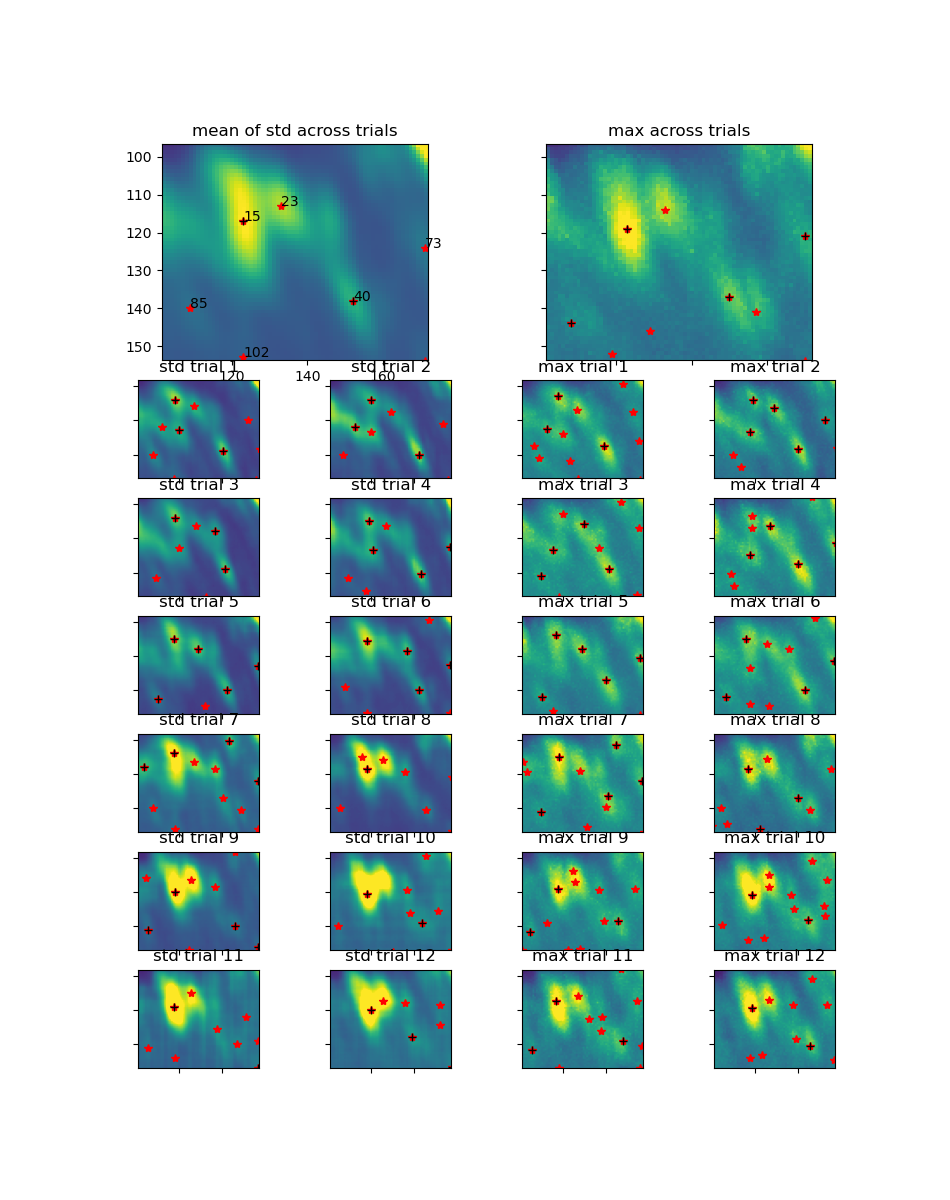

In [57]:
%matplotlib notebook
quantile = 0.99
SHOW_MAX = True

fig = plt.figure(figsize=(9.5, 12))  # contstained_layout=True)
layout = """
    AABB
    AABB
    CDEF
    GHIJ
    KLMN
    OPQR
    STUV
    WXYZ
    """
axs_names = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
ax_dict = fig.subplot_mosaic(layout)  # , sharex=True, sharey=True)
for i_ax, ax_name in enumerate(axs_names):
    if i_ax:
        ax_dict[ax_name].set_xticklabels([])
        ax_dict[ax_name].set_yticklabels([])
        ax_dict[axs_names[0]].get_shared_x_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])
        ax_dict[axs_names[0]].get_shared_y_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])
        

for i_ax, ax_name in enumerate(axs_names):
    ax = ax_dict[axs_names[i_ax]]
    if i_ax == 0:
        im = green_total_std
        title = "mean of std across trials"
    elif i_ax == 1:
        im = green_total_max
        title = "max across trials"
    else:
        i_row = (i_ax - 2) // 4
        i_col = (i_ax - 2) % 4
        if i_col < 2:  # target all the left small subplots
            i_trial = i_row * 2 + i_col
            im = green_stds[i_trial]
            title = "std trial {}".format(i_trial + 1)
        else:
            i_trial = i_row * 2 + i_col - 2
            im = green_maxs[i_trial]
            title = "max trial {}".format(i_trial + 1)
    ax.imshow(im, clim=[0, np.quantile(im, quantile)])
    ax.set_title(title)
    
    if SHOW_MAX:
        coordinates5 = peak_local_max(im, min_distance=5)
        coordinates10 = peak_local_max(im, min_distance=10)
        _ = [ax.plot(pixel[1], pixel[0], 'r*') for pixel in coordinates5]
        _ = [ax.plot(pixel[1], pixel[0], 'k+') for pixel in coordinates10]
        if i_ax == 0:
            for i in range(len(coordinates5)):
                ax.annotate(str(i), np.flip(coordinates5[i]))
    

In [37]:
coordinates5_total_std = peak_local_max(green_total_std, min_distance=5)
for i_c, coord in enumerate(coordinates5):
    print("{:3}: {:3}, {:3}".format(i_c, coord[0], coord[1]))

  0: 137, 595
  1: 139, 612
  2: 136, 584
  3: 135, 605
  4: 112, 539
  5: 104,  88
  6: 133,  47
  7: 154, 357
  8: 106,  73
  9: 120, 125
 10: 115, 132
 11: 152, 622
 12: 172, 283
 13:  88, 175
 14: 115, 481
 15:  98, 271
 16: 172,  97
 17: 159, 275
 18: 128,  89
 19: 100, 473
 20: 172, 144
 21: 155, 578
 22:  89, 187
 23: 185, 337
 24: 199, 520
 25: 148, 225
 26: 118, 473
 27: 152, 403
 28:  88, 160
 29: 100, 429
 30: 193, 283
 31: 224, 467
 32: 186, 547
 33: 108, 307
 34: 142, 537
 35: 201, 193
 36: 142, 528
 37: 211, 196
 38: 182, 377
 39: 163, 592
 40: 222, 211
 41: 122, 316
 42: 189, 477
 43: 199, 480
 44: 180, 571
 45: 216, 132
 46: 144, 561
 47: 205, 140
 48: 195, 121
 49: 168, 573
 50: 187, 356
 51:  91, 241
 52:  98, 217
 53: 116, 145
 54: 184, 437
 55: 123, 332
 56: 182, 112
 57: 124, 368
 58: 160,  73
 59: 172,  57
 60: 172, 244
 61: 233, 425
 62: 182, 128
 63: 172, 555
 64: 181, 181
 65: 126, 557
 66: 232, 439
 67:  98, 284
 68: 177, 460
 69: 208, 507
 70: 170, 304
 71: 2

In [38]:
confirmed_ROIs = [18, 65, 8, 3, 13, 23, 40, 2, 52, 73, 74, 91, 31, 59, 42, 47, 1, 11, 25, 22, 14, 49, 26, 24, 89, 57, 63, 78, 5, 6,33, 45, 
                  7, 28, 30, 81, 4, 0, 20, 29, 21, 39, 35, 27, 36, 55, 54, 61, 19, 62, 41, 53, 50, 72, 68, 79, 69, 66, 94, 60, 16, 12,
                 32, 88, 48, 64, 95, 97, 103, 10, 96, 84, 104, 75, 80, 43, 71, 67, 100, 82, 56, 58, 51, 38, 37, 44, 86, 77, 90, 17, 76, 106,
                 87, 9, 34, 46, 70, 99]
additional_ROIs = [[137, 38],
                   [108, 120], 
                   [126, 125],
                   [98, 298],
                   [94, 285],
                   [112, 481],
                   [145, 529],
                   [138, 561],
                   [126, 555],
                   [105, 551], 
                   [131, 572],
                   [164, 590],
                   [182, 555],
                   [173, 564],
                   [214, 490],
                   [206, 397],
                   [188, 355],
                   [208, 224],
                   [212, 129],
                   [219, 153],
                   [212, 164],
                   [175, 79],
                   [200, 91],
                  [152, 274],
                  [162, 293]]

In [40]:
new_ROIs = np.vstack((coordinates5_total_std[confirmed_ROIs, :], additional_ROIs))
for i_c, coord in enumerate(new_ROIs):
    print("{:3}: {:3}, {:3}".format(i_c, coord[0], coord[1]))

  0: 134,  48
  1: 115,  54
  2: 110,  73
  3: 106,  85
  4: 127,  89
  5: 113, 133
  6: 138, 152
  7:  93, 173
  8: 102, 189
  9: 124, 171
 10: 149, 186
 11: 147, 202
 12: 149, 224
 13: 150, 242
 14: 100, 216
 15:  95, 241
 16:  95, 271
 17: 112, 308
 18: 123, 331
 19: 138, 345
 20: 155, 358
 21: 127, 367
 22: 150, 400
 23: 102, 428
 24: 100, 403
 25: 122, 444
 26: 158, 449
 27: 130, 458
 28: 104, 473
 29: 119, 472
 30: 102, 491
 31: 117, 505
 32: 111, 532
 33: 134, 529
 34: 144, 537
 35: 153, 516
 36: 139, 585
 37: 137, 595
 38: 153, 578
 39: 170, 576
 40: 175, 546
 41: 166, 554
 42: 183, 573
 43: 201, 481
 44: 203, 523
 45: 188, 508
 46: 188, 492
 47: 205, 503
 48: 225, 466
 49: 211, 452
 50: 210, 420
 51: 187, 438
 52: 185, 405
 53: 228, 445
 54: 231, 429
 55: 227, 395
 56: 222, 435
 57: 179, 460
 58: 185, 425
 59: 193, 392
 60: 174, 345
 61: 182, 336
 62: 181, 374
 63: 223, 363
 64: 171, 387
 65: 207, 382
 66: 223, 335
 67: 235, 345
 68: 227, 316
 69: 193, 282
 70: 233, 275
 71: 2

<IPython.core.display.Javascript object>


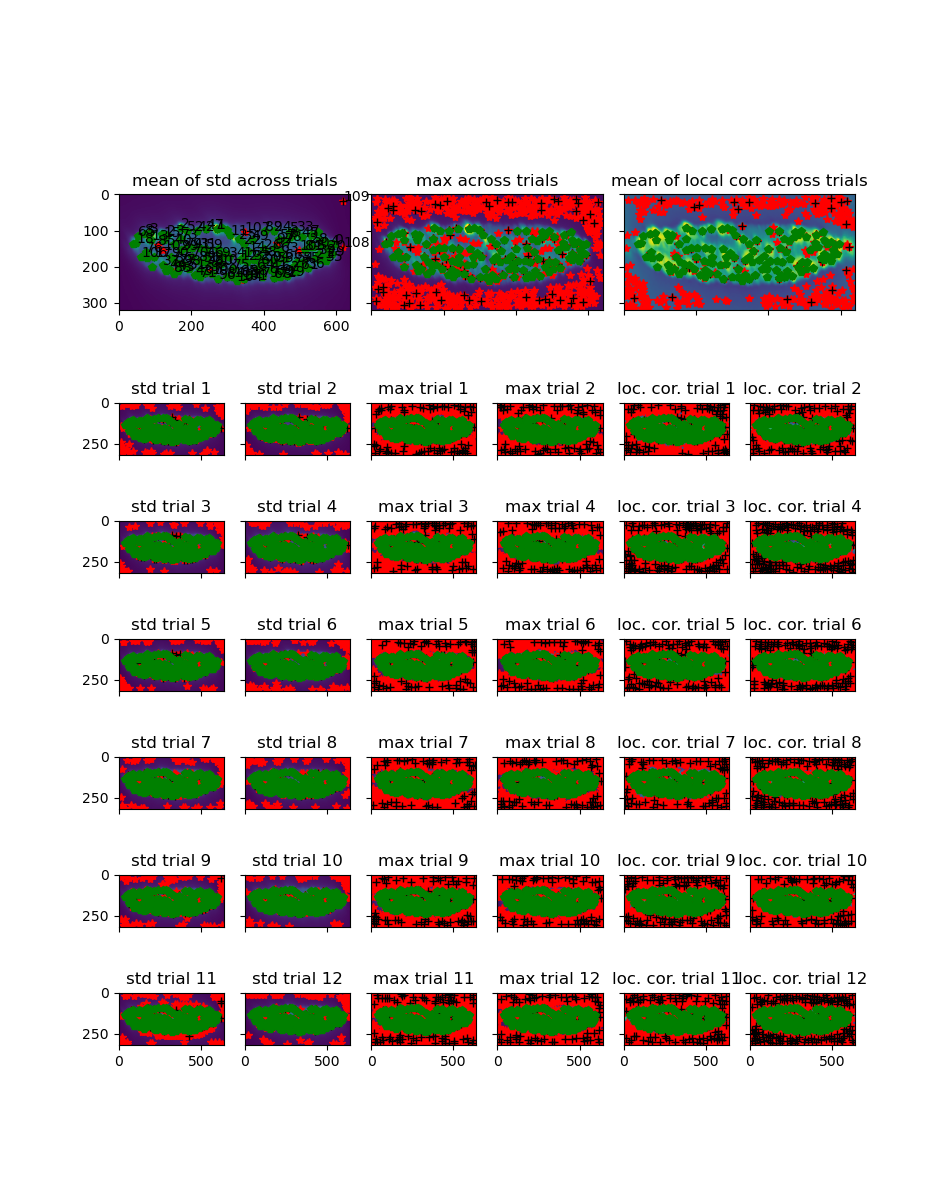

In [41]:
%matplotlib notebook
quantile = 0.99
SHOW_MAX = True
"""
def on_click(event):
    if event.inaxes is not None:
        print(event.ydata, event.xdata)
    else:
        print('Clicked ouside axes bounds but inside plot window')
"""
fig = plt.figure(figsize=(9.5, 12))  # contstained_layout=True)
# fig.canvas.callbacks.connect('button_press_event', on_click)

layout = """
    AABBCC
    AABBCC
    DEFGHI
    JKLMNO
    PQRSTU
    VWXYZa
    bcdefg
    hijklm
    """
axs_names = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklm"
ax_dict = fig.subplot_mosaic(layout)  # , sharex=True, sharey=True)
for i_ax, ax_name in enumerate(axs_names):
    if i_ax:
        ax_dict[axs_names[0]].get_shared_y_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])
        ax_dict[axs_names[0]].get_shared_x_axes().join(ax_dict[axs_names[0]], ax_dict[ax_name])

        if (i_ax - 3) % 6:
            ax_dict[ax_name].set_yticklabels([])
        if not (i_ax - 3) >= 6*5:
            ax_dict[ax_name].set_xticklabels([])
        
        

for i_ax, ax_name in enumerate(axs_names):
    ax = ax_dict[axs_names[i_ax]]
    if i_ax == 0:
        im = green_total_std
        title = "mean of std across trials"
    elif i_ax == 1:
        im = green_total_max
        title = "max across trials"
    elif i_ax == 2:
        im = green_total_local_corr
        title = "mean of local corr across trials"
    else:
        i_row = (i_ax - 3) // 6
        i_col = (i_ax - 3) % 6
        if i_col < 2:  # target all the left small subplots
            i_trial = i_row * 2 + i_col
            im = green_stds[i_trial]
            title = "std trial {}".format(i_trial + 1)
        elif i_col < 4:
            i_trial = i_row * 2 + i_col - 2
            im = green_maxs[i_trial]
            title = "max trial {}".format(i_trial + 1)
        else:
            i_trial = i_row * 2 + i_col - 4
            im = green_local_corrs[i_trial]
            title = "loc. cor. trial {}".format(i_trial + 1)
    ax.imshow(im, clim=[0, np.quantile(im, quantile)])
    ax.set_title(title)
    
    if SHOW_MAX:
        coordinates5 = peak_local_max(im, min_distance=5)
        coordinates10 = peak_local_max(im, min_distance=10)
        _ = [ax.plot(pixel[1], pixel[0], 'r*') for pixel in coordinates5]
        _ = [ax.plot(pixel[1], pixel[0], 'k+') for pixel in coordinates10]
        if i_ax == 0:
            for i in range(len(coordinates5)):
                ax.annotate(str(i), np.flip(coordinates5[i]))
                
    _ = [ax.plot(pixel[1], pixel[0], 'gp') for pixel in new_ROIs]


<IPython.core.display.Javascript object>


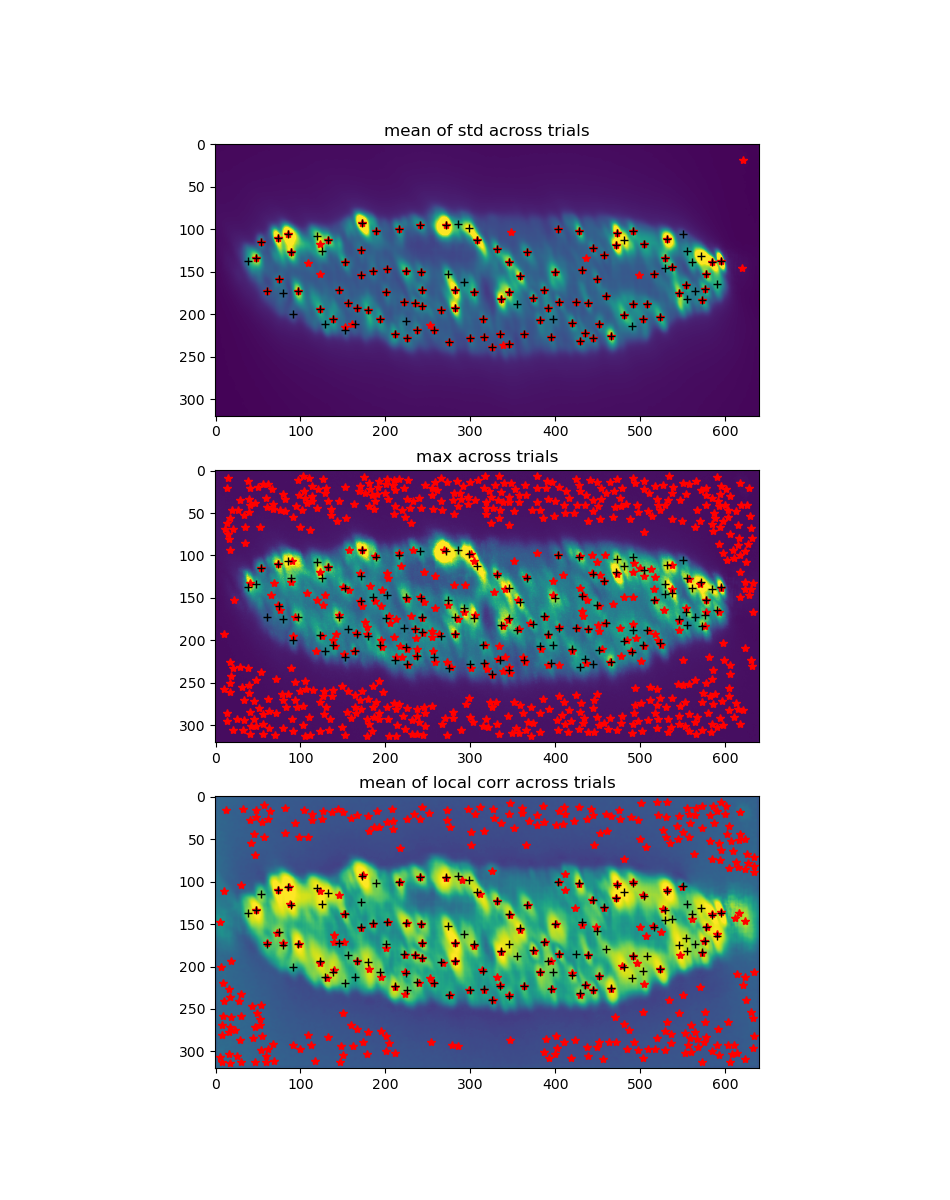

In [51]:
%matplotlib notebook
quantile = 0.99
"""
def on_click(event):
    if event.inaxes is not None:
        print(event.ydata, event.xdata)
    else:
        print('Clicked ouside axes bounds but inside plot window')
"""
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9.5, 12))
        
        

for i_ax, ax in enumerate(axs):
    if i_ax == 0:
        im = green_total_std
        title = "mean of std across trials"
    elif i_ax == 1:
        im = green_total_max
        title = "max across trials"
    elif i_ax == 2:
        im = green_total_local_corr
        title = "mean of local corr across trials"
    ax.imshow(im, clim=[0, np.quantile(im, quantile)])
    ax.set_title(title)

    coordinates5 = peak_local_max(im, min_distance=5)
    _ = [ax.plot(pixel[1], pixel[0], 'r*') for pixel in coordinates5]
    _ = [ax.plot(pixel[1], pixel[0], 'k+') for pixel in new_ROIs]
    if i_ax == -1:
        for i in range(len(new_ROIs)):
            ax.annotate(str(i), np.flip(new_ROIs[i]))
                

